<a href="https://colab.research.google.com/github/kmjhyn/NLP-Short-Text-Sentiment-Analysis/blob/main/ML_with_Twitter_and_YT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis with ML
```yaml
Original Code: https://www.kaggle.com/datasets/kazanova/sentiment140
Editor: Ji Hyun Kim

note:
this notebook contains code for sentiment analysis on both twitter dataset and YouTube dataset.
Both are pre-processed, but training is done based on Twitter and the pickled model is used to analyze YouTube dataset.

```


In [ ]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer
#additional nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
#additional sklearn
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing dataset

The dataset being used is the **sentiment140 dataset**. It contains 1,600,000 tweets extracted using the Twitter API. It contains the following 6 fields:

- **sentiment**: the polarity of the tweet
- ids: The id of the tweet
- date: the date of the tweet
- flag: The query. If there is no query, then this value is NO_QUERY.
- user: the user that tweeted
- **text**: the text of the tweet

We require only the **sentiment** and **text** fields, so we discard the rest and change the value of sentiment as **0 = Negative and 1 = Positive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [ ]:
#config
data_dir = '/content/drive/MyDrive/24Spring/NLP'
data_dir

'/content/drive/MyDrive/24Spring/NLP'

<ipython-input-7-ccd8eca2c5fc>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['sentiment'] = dataset['sentiment'].replace(4,1)


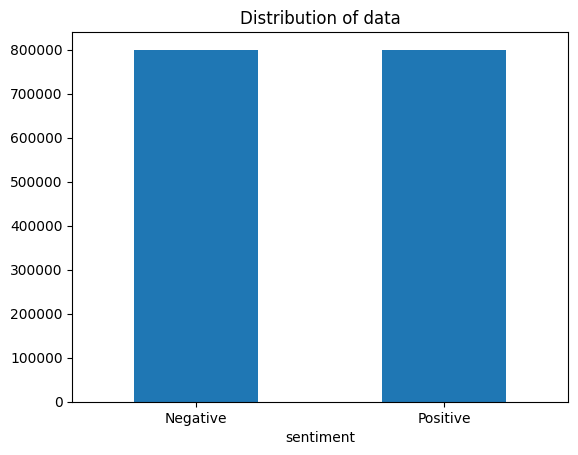

In [ ]:
# Importing the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv(f'{data_dir}/training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]
# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

# Plotting the distribution for dataset.
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data', legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, sentiment_1 = list(dataset['text']), list(dataset['sentiment'])

## Preprocess Text
- Lower Casing: Each text is converted to lowercase.
- Replacing URLs: Links starting with "http" or "https" or "www" are replaced by "URL".
- Replacing Emojis: Replace emojis by using a pre-defined dictionary containing emojis along with their meaning. (eg: ":)" to "EMOJIsmile")
- Replacing Usernames: Replace @Usernames with word "USER". (eg: "@Kaggle" to "USER")
- Removing Non-Alphabets: Replacing characters except Digits and Alphabets with a space.
- Removing Consecutive letters: 3 or more consecutive letters are replaced by 2 letters. (eg: "Heyyyy" to "Heyy")
- Removing Short Words: Words with length less than 2 are removed.

In [ ]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

stopwordlist = set(stopwords.words('english'))

# for w in word_tokens:
#     if w not in stop_words:
#         filtered_sentence.append(w)


def preprocess(textdata):
    # filtered_sentence = []
    processedText = []

    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()

    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"

    for tweet in textdata:
        tweet = tweet.lower()

        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            if word in stopwordlist:
              continue

            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')

        processedText.append(tweetwords)

    return processedText

In [ ]:
# stopwordlist

In [ ]:
import time
t = time.time()
processedtext_1 = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

NameError: name 'text' is not defined

## Processing YouTube dataset
This code is for YouTube comments pre-processing
The variable `feature_num` will be used later for training Twitter dataset to align the number of features within the trained model to test the YouTube comments dataset.

In [ ]:
comments = pd.read_csv(f'{data_dir}/youtube_ai_comments_20240419_17_57.csv').astype(str)
comments_colums = ["id", "unnamed: 0", "author", "published_at", "updated_at", "like_count", "text"]

text_comments = list(comments['text'])

t = time.time()
processedcomments = preprocess(text_comments)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

X_train_c = processedcomments

vectoriser_c = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser_c.fit(X_train_c)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser_c.get_feature_names_out()))

X_train_c = vectoriser_c.transform(X_train_c)
print(f'Data Transformed.')
feature_num = len(vectoriser_c.get_feature_names_out())

Text Preprocessing complete.
Time Taken: 0 seconds
Vectoriser fitted.
No. of feature_words:  14868
Data Transformed.


In [ ]:
# processedcomments

## Further Processing

### Splitting the Data

1.6million data points were too big for BERT model, so we scaled dataset into 250,000. ML algorithms were done the same for consistency with BERT.\
Then, data is divided into 2 sets
- Training: 70%
- Testing: 30%

In [ ]:
# processedtext_1[:1]
#1,600,000 (80000까지 sentiment 0, 그다음부터 쭉 sentiment 1)
text_0 = processedtext_1[:800000]
text_1 = processedtext_1[800000:]
text_0_new = text_0[:125000]
text_1_new = text_1[:125000]
processedtext=text_0_new + text_1_new

NameError: name 'processedtext_1' is not defined

In [ ]:
# processedtext[:1]
len(processedtext)

250000

In [ ]:
sentiment_0 = sentiment_1[:800000]
sentiment_1 = sentiment_1[800000:]
sentiment_0_new = sentiment_0[:125000]
sentiment_1_new = sentiment_1[:125000]
sentiment=sentiment_0_new + sentiment_1_new

In [ ]:
len(sentiment)

250000

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment, test_size = 0.3, random_state = 0)
print(f'Data Split done.')
print(len(X_train))
print(len(X_test))
print(len(y_train))

Data Split done.
175000
75000
175000


### TF-IDF Vectoriser
tfidf vectoriser trained on x_train dataset\
`ngram_range` = (1,2 )\
`max_feature` = `feature_num`

In [ ]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=feature_num)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

Vectoriser fitted.
No. of feature_words:  19764


### Tranforming the dataset

In [ ]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


In [ ]:
print(X_train.shape)
print(X_test.shape)

(175000, 19764)
(75000, 19764)


## Creating and Evaluating Models
**5 different types of model**

- Naive Bayes
- LinearSVC
- Logistic Regression
- Random Forest
- Gradient Boosting

### Evaluate Model Function

In [ ]:
def model_Evaluate(model):

    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

## Results

### Naive Bayes

              precision    recall  f1-score   support

           0       0.79      0.78      0.78     37510
           1       0.78      0.79      0.79     37490

    accuracy                           0.78     75000
   macro avg       0.78      0.78      0.78     75000
weighted avg       0.78      0.78      0.78     75000



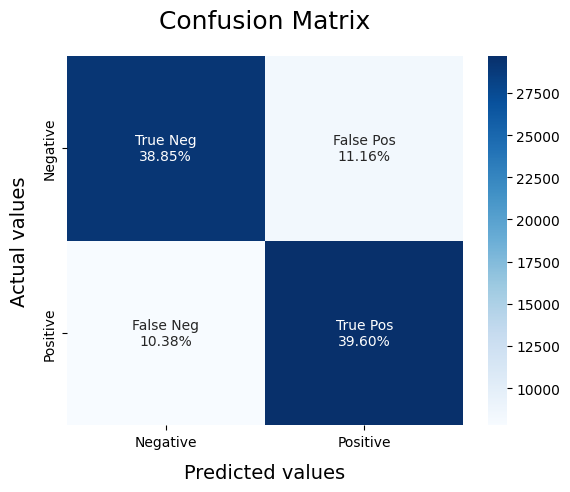

In [ ]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

### LinearSVC Model

              precision    recall  f1-score   support

           0       0.80      0.79      0.80     37510
           1       0.79      0.81      0.80     37490

    accuracy                           0.80     75000
   macro avg       0.80      0.80      0.80     75000
weighted avg       0.80      0.80      0.80     75000



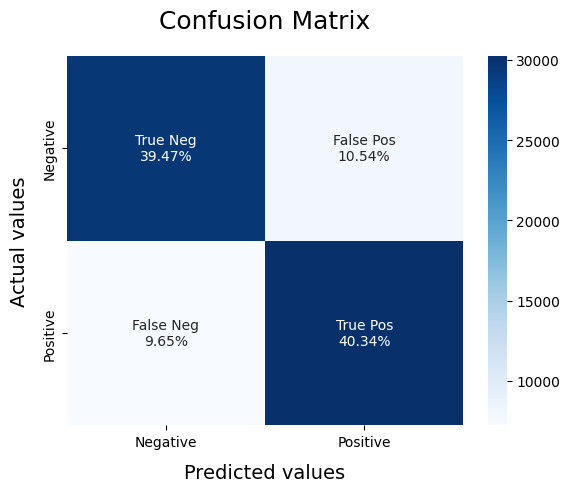

In [ ]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

### Logistic Regression Model

              precision    recall  f1-score   support

           0       0.81      0.80      0.80     37510
           1       0.80      0.81      0.81     37490

    accuracy                           0.81     75000
   macro avg       0.81      0.81      0.81     75000
weighted avg       0.81      0.81      0.81     75000



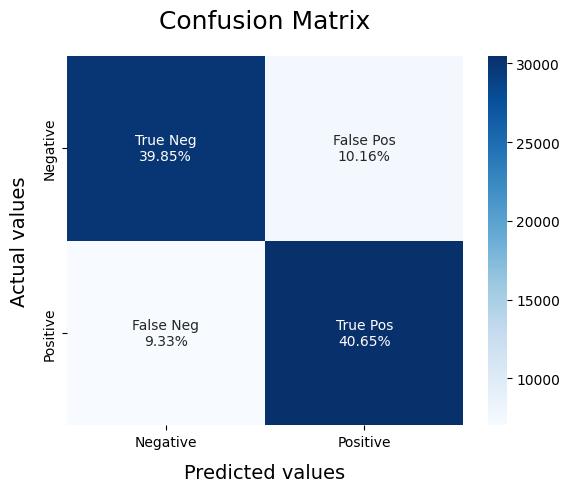

In [ ]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

### RandomForestClassifier
뚝떨어짐 70%accuracy

              precision    recall  f1-score   support

           0       0.70      0.72      0.71     37510
           1       0.71      0.68      0.70     37490

    accuracy                           0.70     75000
   macro avg       0.70      0.70      0.70     75000
weighted avg       0.70      0.70      0.70     75000



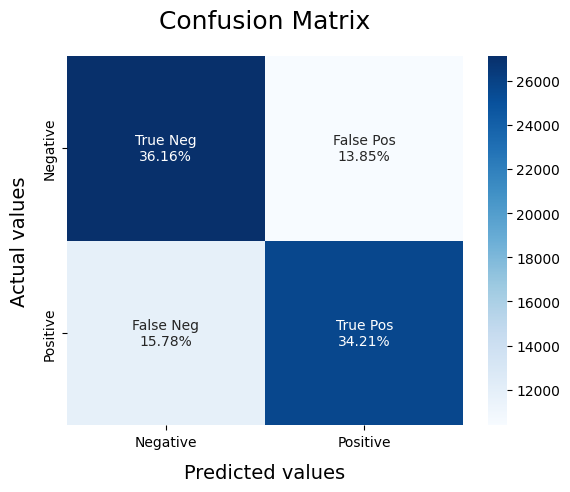

In [ ]:
RFmodel = RandomForestClassifier(max_depth=4, random_state=0)
RFmodel.fit(X_train, y_train)
model_Evaluate(RFmodel)

### GradientBoostingClassifier

              precision    recall  f1-score   support

           0       0.71      0.76      0.74     37510
           1       0.74      0.70      0.72     37490

    accuracy                           0.73     75000
   macro avg       0.73      0.73      0.73     75000
weighted avg       0.73      0.73      0.73     75000



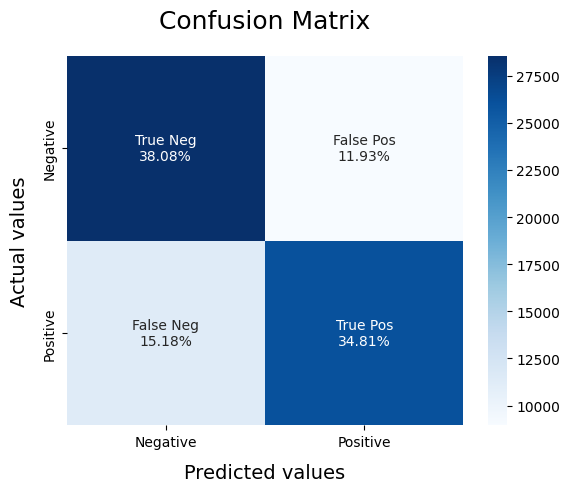

In [ ]:
GBmodel = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
GBmodel.fit(X_train, y_train)
model_Evaluate(GBmodel)

## Saving the Models
We're using PICKLE to save Vectoriser and BernoulliNB, Logistic Regression Model for later use.

In [ ]:
file = open('vectoriser_youtube.pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('Sentiment-LR-youtube.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

file = open('Sentiment-BNB-youtube.pickle','wb')
pickle.dump(BNBmodel, file)
file.close()

file = open('Sentiment-SVC-youtube.pickle','wb')
pickle.dump(SVCmodel, file)
file.close()

file = open('Sentiment-RF-youtube.pickle','wb')
pickle.dump(RFmodel, file)
file.close()

file = open('Sentiment-GB-youtube.pickle','wb')
pickle.dump(GBmodel, file)
file.close()

# Using the Model.
To use the model for Sentiment Prediction we need to import the Vectoriser and LR Model using Pickle.

The vectoriser can be used to transform data to matrix of TF-IDF Features. While the model can be used to predict the sentiment of the transformed Data. The text whose sentiment has to be predicted however must be preprocessed.

In [ ]:
from nltk.corpus import stopwords

In [ ]:
def load_models():
    '''
    path for pickled models
    '''

    # /content/drive/MyDrive/Sentiment-LR-youtube.pickle
    # /content/drive/MyDrive/Sentiment-BNB-youtube.pickle
    # /content/drive/MyDrive/Sentiment-SVC-youtube.pickle
    # /content/drive/MyDrive/Sentiment-RF-youtube.pickle
    # /content/drive/MyDrive/Sentiment-GB-youtube.pickle
    # /content/drive/MyDrive/vectoriser_youtube.pickle

    # Load the vectoriser.
    file = open('/content/drive/MyDrive/vectoriser_youtube.pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()

    # Load the LR Model.
    file = open('/content/drive/MyDrive/Sentiment-LR-youtube.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()

    # Load the BNB Model.
    file = open('/content/drive/MyDrive/Sentiment-BNB-youtube.pickle', 'rb')
    BNBmodel = pickle.load(file)
    file.close()

    # Load the SVC Model.
    file = open('/content/drive/MyDrive/Sentiment-SVC-youtube.pickle', 'rb')
    SVCmodel = pickle.load(file)
    file.close()

    # Load the RF Model.
    file = open('/content/drive/MyDrive/Sentiment-RF-youtube.pickle', 'rb')
    RFmodel = pickle.load(file)
    file.close()

    # Load the GB Model.
    file = open('/content/drive/MyDrive/Sentiment-GB-youtube.pickle', 'rb')
    GBmodel = pickle.load(file)
    file.close()

    return vectoriser, LRmodel, BNBmodel, SVCmodel, RFmodel, GBmodel

In [ ]:
vectoriser, LRmodel, BNBmodel, SVCmodel, RFmodel, GBmodel = load_models()

In [ ]:
def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)

    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))

    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

In [ ]:
'''
put youtube dataset using pickel model for results
'''

text = processedcomments
df_LR = predict(vectoriser, LRmodel, text)
df_BNB = predict(vectoriser, BNBmodel, text)
df_SVC = predict(vectoriser, SVCmodel, text)
df_RF = predict(vectoriser, RFmodel, text)
df_GB = predict(vectoriser, GBmodel, text)

# df_BNB = predict(vectoriser, LRmodel, text)

# if __name__=="__main__":
#     # Loading the models.
#     vectoriser, LRmodel = load_models()

#     # Text to classify should be in a list.
#     text = processedcomments

#     df = predict(vectoriser, LRmodel, text)
#     print(df.head())
#     df

In [ ]:
df_LR.head()
# df_BNB.head()
# df_SVC.head()
# df_RF.head()
# df_GB.head()

,text,sentiment
0,productive br 39 much rather learn chill happy...,Positive
1,simple rich get richer ai poor remain poor,Negative
2,eventually artificial intelligence take human ...,Positive
3,side ai big city like berlin london highest co...,Positive
4,quot 39 making machine human like make human m...,Positive


## Save Youtube Analysis Results
using pickled ml models

In [ ]:
df_BNB.to_csv('youtube_ai_BNB_test_nltkstopwords.csv')
df_SVC.to_csv('youtube_ai_SVC_test_nltkstopwords.csv')
df_LR.to_csv('youtube_ai_LR_test_nltkstopwords.csv')
df_RF.to_csv('youtube_ai_RF_test_nltkstopwords.csv')
df_GB.to_csv('youtube_ai_GB_test_nltkstopwords.csv')